In [1]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("Is GPU used by default:", tf.test.is_built_with_cuda())
print("GPU device name:", tf.test.gpu_device_name())


2025-07-08 11:14:10.119906: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751973250.162351     349 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751973250.172576     349 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Num GPUs Available: 2
Is GPU used by default: True
GPU device name: /device:GPU:0


I0000 00:00:1751973254.179371     349 gpu_device.cc:2022] Created device /device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751973254.180028     349 gpu_device.cc:2022] Created device /device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [2]:
import os
import shutil
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [3]:
# #use this code, only if you  are reducing the subset data size, if increase below code works fine.
# import glob

# def clear_folder(path):
#     for file in glob.glob(os.path.join(path, '*')):
#         os.remove(file)

# # Example
# clear_folder("subset_dataset/train/0")
# clear_folder("subset_dataset/train/1")
# clear_folder("subset_dataset/test/0")
# clear_folder("subset_dataset/test/1")


In [4]:

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'      # Suppress INFO and DEBUG logs
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'  # Optional: manage memory better
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'     # Optional: suppress extra oneDNN messages


In [5]:
# Source: full dataset
source_path = "/kaggle/input/idc-organized-data-zipfile"

# Target: new small subset
target_path = "subset_dataset"

# Sample sizes
sample_config = {
    'train': { '0': 75000, '1': 65000 },
    'validation': { '0': 8000, '1': 8000 },
    'test':  { '0': 4000,  '1': 4000 }
}

def make_dirs():
    for split in sample_config:
        for cls in ['0', '1']:
            os.makedirs(os.path.join(target_path, split, cls), exist_ok=True)

def copy_samples(split_from, split_to, class_label, n_samples):
    src_dir = os.path.join(source_path, split_from, class_label)
    dst_dir = os.path.join(target_path, split_to, class_label)

    os.makedirs(dst_dir, exist_ok=True)

    all_files = os.listdir(src_dir)
    dst_files = os.listdir(dst_dir)

    already_copied = len(dst_files)
    to_copy = n_samples - already_copied

    if to_copy <= 0:
        print(f"✔️ {split_to}/{class_label}: Already has {already_copied} files. Skipping.")
        return

    available_files = [f for f in all_files if f not in dst_files]

    if to_copy > len(available_files):
        raise ValueError(f"❌ Not enough new files in {split_from}/{class_label} to copy {to_copy} files. Only {len(available_files)} available.")

    selected = random.sample(available_files, to_copy)

    for fname in selected:
        shutil.copy2(os.path.join(src_dir, fname), os.path.join(dst_dir, fname))

    print(f"📦 {split_to}/{class_label}: Copied {to_copy} new files (total: {already_copied + to_copy})")

def create_subset():
    make_dirs()

    print("📁 Creating training subset...")
    copy_samples('train', 'train', '0', sample_config['train']['0'])
    copy_samples('train', 'train', '1', sample_config['train']['1'])

    print("📁 Creating validation subset...")
    copy_samples('train', 'validation', '0', sample_config['validation']['0'])
    copy_samples('train', 'validation', '1', sample_config['validation']['1'])

    print("📁 Creating test subset...")
    copy_samples('test', 'test', '0', sample_config['test']['0'])
    copy_samples('test', 'test', '1', sample_config['test']['1'])

    print("✅ Subset creation complete!")

# Run
create_subset()


📁 Creating training subset...
✔️ train/0: Already has 75000 files. Skipping.
✔️ train/1: Already has 65000 files. Skipping.
📁 Creating validation subset...
✔️ validation/0: Already has 8000 files. Skipping.
✔️ validation/1: Already has 8000 files. Skipping.
📁 Creating test subset...
✔️ test/0: Already has 4000 files. Skipping.
✔️ test/1: Already has 4000 files. Skipping.
✅ Subset creation complete!



Class 0 (label: Normal):


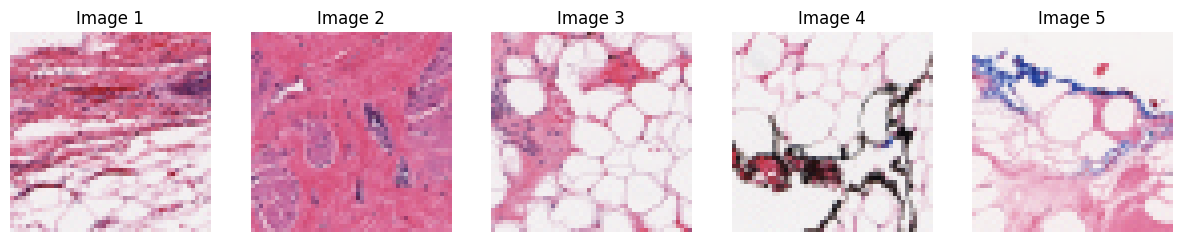


Class 1 (label: IDC):


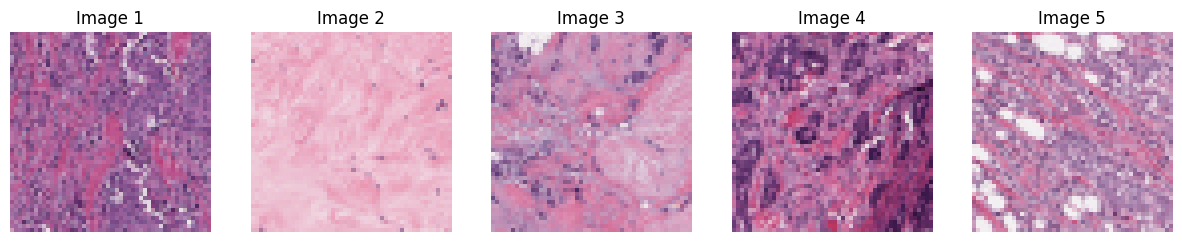

In [6]:
from PIL import Image

# Set your folder
data_dir = "subset_dataset/train"
classes = ['0', '1']

# Show 5 random images from each class
for cls in classes:
    class_dir = os.path.join(data_dir, cls)
    image_files = random.sample(os.listdir(class_dir), 5)

    print(f"\nClass {cls} (label: {'Normal' if cls == '0' else 'IDC'}):")

    plt.figure(figsize=(15, 3))
    for i, file in enumerate(image_files):
        img_path = os.path.join(class_dir, file)
        img = Image.open(img_path)
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.title(f"Image {i+1}")
        plt.axis('off')
    plt.show()

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (128, 128)
batch_size = 32

datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
 )

train_gen = datagen.flow_from_directory(
    'subset_dataset/train',
    target_size = img_size,
    class_mode = 'binary',
    batch_size = batch_size,
    shuffle = True
)

val_datagen = ImageDataGenerator(
    rescale=1./255
) 

val_gen = val_datagen.flow_from_directory(
    'subset_dataset/validation',
    target_size = img_size,
    class_mode = 'binary',
    batch_size = batch_size,
    shuffle = False
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

test_gen = test_datagen.flow_from_directory(
    'subset_dataset/test',
    target_size = img_size,
    class_mode = 'binary',
    batch_size = batch_size,
    shuffle = False
)

Found 140000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization, Activation,
                                     SeparableConv2D, GlobalAveragePooling2D, Dropout, Dense)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


input_tensor = Input(shape=(128, 128, 3))

# Block 1
x = Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(0.001))(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Block 2
x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Block 3
x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Block 4 (Deeper with SeparableConv2D)
x = SeparableConv2D(256, (3, 3), padding='same', depthwise_regularizer=l2(0.001), pointwise_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = GlobalAveragePooling2D()(x)

x = Dropout(0.5)(x)
x = Dense(128, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Dropout(0.3)(x)
x = Dense(64, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Output Layer
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_tensor, outputs=output)
model.summary()


I0000 00:00:1751973261.489388     349 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751973261.489650     349 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d (SeparableConv2D)   │ (None, 16, 16, 256)         │          34,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │              

 Total params: 171,329 (669.25 KB)

 Trainable params: 169,985 (664.00 KB)

 Non-trainable params: 1,344 (5.25 KB)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1, min_lr=1e-6)
]

model.compile(
    optimizer='Adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(train_gen,
         validation_data=val_gen,
         callbacks=callbacks,
         epochs=100)

test_scores = model.evaluate(test_gen)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1751973269.405654     425 service.cc:148] XLA service 0x7fa67804ca20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751973269.405703     425 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751973269.405710     425 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751973270.014133     425 cuda_dnn.cc:529] Loaded cuDNN version 90300


   3/4375 ━━━━━━━━━━━━━━━━━━━━ 6:01 83ms/step - accuracy: 0.4861 - loss: 1.3795   

I0000 00:00:1751973275.323818     425 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4375/4375 ━━━━━━━━━━━━━━━━━━━━ 642s 144ms/step - accuracy: 0.7947 - loss: 0.7055 - val_accuracy: 0.8317 - val_loss: 0.4426 - learning_rate: 0.0010
Epoch 2/100
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 624s 143ms/step - accuracy: 0.8275 - loss: 0.4427 - val_accuracy: 0.6835 - val_loss: 0.6661 - learning_rate: 0.0010
Epoch 3/100
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 623s 142ms/step - accuracy: 0.8317 - loss: 0.4257 - val_accuracy: 0.8161 - val_loss: 0.4563 - learning_rate: 0.0010
Epoch 4/100
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8361 - loss: 0.4169
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 611s 140ms/step - accuracy: 0.8361 - loss: 0.4169 - val_accuracy: 0.7731 - val_loss: 0.5064 - learning_rate: 0.0010
Epoch 5/100
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 615s 141ms/step - accuracy: 0.8452 - loss: 0.3925 - val_accuracy: 0.8556 - val_loss: 0.3629 - learning_rate: 5.0000e-04
Epoch 6/100
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step -

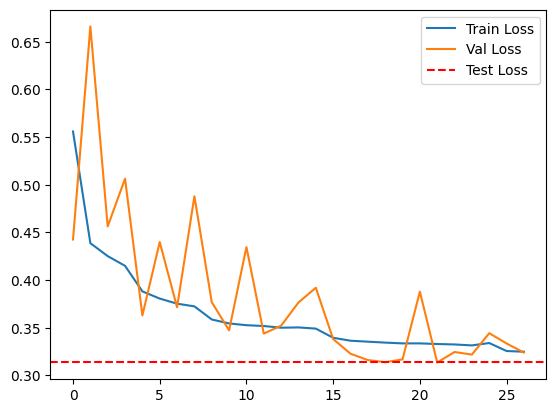

In [10]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.axhline(y=test_scores[0], color='r', linestyle='--', label='Test Loss')
plt.legend()
plt.show()


In [11]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(test_gen)
Y_pred = (Y_pred > 0.5).astype(int)

print(classification_report(test_gen.classes, Y_pred))
print(confusion_matrix(test_gen.classes, Y_pred))


250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      4000
           1       0.85      0.91      0.88      4000

    accuracy                           0.88      8000
   macro avg       0.88      0.88      0.88      8000
weighted avg       0.88      0.88      0.88      8000

[[3352  648]
 [ 343 3657]]


# Time For Grad-CAM XAI



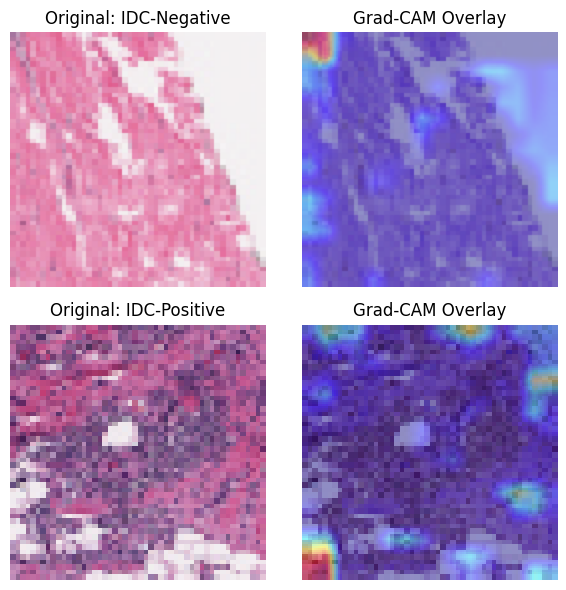

In [50]:
plt.figure(figsize=(6, 6))

for idx, (class_label, image_array) in enumerate(sorted_items):
    # Grad-CAM setup
    grad_model = Model(
        inputs=model.input,
        outputs=[
            model.get_layer('separable_conv2d').output,
            model.output
        ]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(tf.expand_dims(image_array, axis=0))
        loss = predictions[0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap + 1e-8)
    heatmap = heatmap.numpy()

    # Resize heatmap to match image
    heatmap_resized = cv2.resize(heatmap, (image_array.shape[1], image_array.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(np.uint8(image_array * 255), 0.6, heatmap_colored, 0.4, 0)
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    # Plot original image
    plt.subplot(2, 2, idx * 2 + 1)
    plt.imshow(image_array)
    plt.title(f"Original: {'IDC-Positive' if class_label == 1 else 'IDC-Negative'}")
    plt.axis(False)

    # Plot heatmap overlay
    plt.subplot(2, 2, idx * 2 + 2)
    plt.imshow(superimposed_img)
    plt.title("Grad-CAM Overlay")
    plt.axis(False)

plt.tight_layout()
plt.show()
